<a href="https://colab.research.google.com/github/psj03283/resume/blob/main/PAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Import Library**

In [ ]:
!pip install -q tensorflow
!pip install efficientnet
!pip install tensorflow_addons

ERROR: Could not find a version that satisfies the requirement tensorflow-gpu==2.0.0-rc1 (from versions: 2.12.0)
ERROR: No matching distribution found for tensorflow-gpu==2.0.0-rc1


ImportError: /usr/local/lib/python3.11/dist-packages/tensorflow/python/_pywrap_tfe.so: undefined symbol: _ZN4absl12lts_202308026Status15UnrefNonInlinedEm

In [ ]:
import os
os.kill(os.getpid(), 9)

In [ ]:
import tensorflow as tf

In [ ]:
from tqdm import tqdm_notebook
ram=[]
for i in tqdm_notebook(range(100)):
  ram.append("randomword"*i)

/tmp/ipython-input-58-2252751400.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook(range(100)):


  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np
import os
import time
import os, glob, cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from tensorflow.python.keras.utils import get_custom_objects
import efficientnet.tfkeras as efn
from tqdm import tqdm
#import tensorflow_addons as tfa
import openpyxl

In [ ]:
SEED = 42
def seed_everything(seed):
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#LBCP dataset
df = pd.DataFrame(0, columns=['paths','disease'],index=range(978))
#NILM=0
IMG_ROOT_0='/content/drive/My Drive/pap_smear/NILM'
filepaths = glob.glob(IMG_ROOT_0 + '*/*')
cnt=0
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df.iloc[cnt,0]=filepath[0] + '/' + filepath[1]
    df.iloc[cnt,1]=0
    cnt+=1

#LSIL=1
IMG_ROOT_1='/content/drive/My Drive/pap_smear/LSIL'
filepaths = glob.glob(IMG_ROOT_1 + '*/*')
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df.iloc[cnt,0]=filepath[0] + '/' + filepath[1]
    df.iloc[cnt,1]=1
    cnt+=1

#HSIL=2
IMG_ROOT_2='/content/drive/My Drive/pap_smear/HSIL'
filepaths = glob.glob(IMG_ROOT_2 + '*/*')
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df.iloc[cnt,0]=filepath[0] + '/' + filepath[1]
    df.iloc[cnt,1]=2
    cnt+=1

#SCC=3
IMG_ROOT_3='/content/drive/My Drive/pap_smear/SCC'
filepaths = glob.glob(IMG_ROOT_3 + '*/*')
for i, filepath in enumerate(filepaths):
    filepath = os.path.split(filepath)
    df.iloc[cnt,0]=filepath[0] + '/' + filepath[1]
    df.iloc[cnt,1]=3
    cnt+=1
print("\n")

print(len(df['paths']))
df



978


/tmp/ipython-input-65-1835768572.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '/content/drive/My Drive/pap_smear/NILM/NL_2_ (6).jpg' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.iloc[cnt,0]=filepath[0] + '/' + filepath[1]


,paths,disease
0,/content/drive/My Drive/pap_smear/NILM/NL_2_ (...,0
1,/content/drive/My Drive/pap_smear/NILM/NL_7_ (...,0
2,/content/drive/My Drive/pap_smear/NILM/NL_37_ ...,0
3,/content/drive/My Drive/pap_smear/NILM/NL_39_ ...,0
4,/content/drive/My Drive/pap_smear/NILM/NL_25_ ...,0
...,...,...
973,/content/drive/My Drive/pap_smear/SCC/scc_2 (1...,3
974,/content/drive/My Drive/pap_smear/SCC/SCC_4 (3...,3
975,/content/drive/My Drive/pap_smear/SCC/scc_2 (2...,3
976,/content/drive/My Drive/pap_smear/SCC/SCC_3 (4...,3


In [ ]:
print('Number of eye images')
print(df['disease'].value_counts())

Number of eye images
disease
0    628
2    163
1    113
3     74
Name: count, dtype: int64


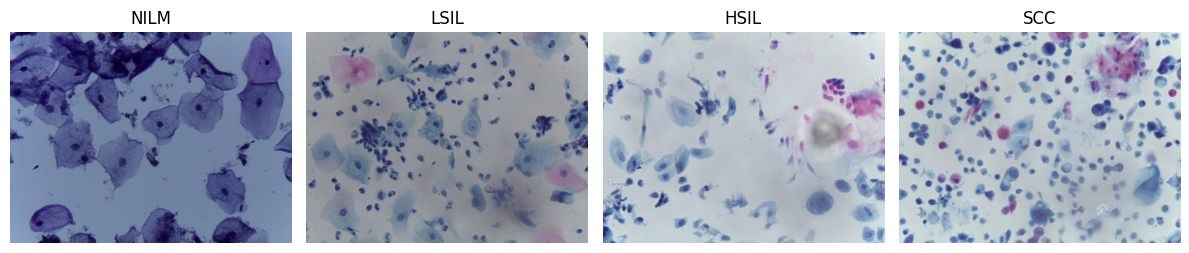

In [ ]:
import matplotlib.pyplot as plt
import cv2

# Class names for labeling
class_names = {0: 'NILM', 1: 'LSIL', 2: 'HSIL', 3: 'SCC'}

# Set up a plot
plt.figure(figsize=(12, 6))

# Show one **random** image per class
for idx, label in enumerate(sorted(df['disease'].unique())):
    # Randomly sample one row for this class
    sample_path = df[df['disease'] == label].sample(1)['paths'].iloc[0]

    # Read and convert image
    img = cv2.imread(sample_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Plot
    plt.subplot(1, 4, idx + 1)
    plt.imshow(img)
    plt.title(class_names[label])
    plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import cv2
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

# Make a copy of original DataFrame
aug_df = df.copy()

# Augmentation function
def rotate_image(image, angle):
    h, w = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    return cv2.warpAffine(image, matrix, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)

for i in tqdm(range(len(df))):
    orig_path = df.iloc[i]['paths']
    label = df.iloc[i]['disease']

    # Read image
    img = cv2.imread(orig_path)
    if img is None:
        print(f"⚠️ Skipping unreadable image: {orig_path}")
        continue

    # Extract class name (e.g., 'NILM')
    class_name = orig_path.split('/')[-2]
    save_dir = f"/content/drive/My Drive/pap_smear_aug/{class_name}"
    os.makedirs(save_dir, exist_ok=True)

    # Base name for new images
    base, ext = os.path.splitext(os.path.basename(orig_path))

    # 1. Horizontal flip
    h_flip = cv2.flip(img, 1)
    h_path = os.path.join(save_dir, f"{base}_hflip{ext}")
    if cv2.imwrite(h_path, h_flip):
        aug_df.loc[len(aug_df)] = [h_path, label]

    # 2. Vertical flip
    v_flip = cv2.flip(img, 0)
    v_path = os.path.join(save_dir, f"{base}_vflip{ext}")
    if cv2.imwrite(v_path, v_flip):
        aug_df.loc[len(aug_df)] = [v_path, label]

    # 3. Random rotation between -10 and 10 degrees
    angle = np.random.uniform(-10, 10)
    rotated = rotate_image(img, angle)
    r_path = os.path.join(save_dir, f"{base}_rot{ext}")
    if cv2.imwrite(r_path, rotated):
        aug_df.loc[len(aug_df)] = [r_path, label]

# Done
print("✅ Augmentation complete")
print("Original size:", len(df))
print("Augmented size:", len(aug_df))


100%|██████████| 978/978 [03:22<00:00,  4.82it/s]

✅ Augmentation complete
Original size: 978
Augmented size: 3912


In [ ]:
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU detected:", tf.config.list_physical_devices('GPU'))

# Quick test operation on GPU
with tf.device('/GPU:0'):
    a = tf.random.normal([1000, 1000])
    b = tf.random.normal([1000, 1000])
    c = tf.matmul(a, b)

print("✅ Matrix multiplication complete")

TensorFlow version: 2.19.0
GPU detected: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ Matrix multiplication complete


In [ ]:
!nvidia-smi


Sat Jun 21 02:06:03 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   48C    P0             28W /   70W |     144MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

 Tesla T4 GPU in Google Colab

In [ ]:
#I didn't add color deconvolution yet.

In [ ]:
train_df, test_df = train_test_split(aug_df,
                                     test_size=0.2,
                                     random_state=SEED,
                                     stratify=aug_df['disease'])

train_df, val_df = train_test_split(train_df,
                                    test_size=0.15,
                                    random_state=SEED,
                                    stratify=train_df['disease'])

In [ ]:
SEED = 42
EPOCHS = 30
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input
def create_datasets(aug_df, img_width, img_height):
    imgs = []
    for path in tqdm(aug_df['paths']):
        if os.path.exists(path):

            img = cv2.imread(path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, (img_width, img_height))
            img = preprocess_input(img)  # Handles scale + normalization:
            #Converts Image to Float 32
            #Rescales Pixels to [-1, 1];  [0, 255] → to [−1.0, 1.0]
            imgs.append(img)
        else:
            print(path)

    aug_df = pd.get_dummies(aug_df['disease'])
    return imgs, aug_df


train_imgs, train_df = create_datasets(train_df, IMG_WIDTH, IMG_HEIGHT)
val_imgs, val_df = create_datasets(val_df, IMG_WIDTH, IMG_HEIGHT)
test_imgs, test_df = create_datasets(test_df, IMG_WIDTH, IMG_HEIGHT)

100%|██████████| 783/783 [00:29<00:00, 26.92it/s]


In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [ ]:
!pip install keras-metrics

In [ ]:
import keras_metrics as km

In [ ]:
def build_model(img_height, img_width, n):
    inp = Input(shape=(img_height,img_width,n))
    efnet = efn.EfficientNetB0(
        input_shape=(img_height,img_width,n),
        weights='imagenet',
        include_top=False
    )
    x = efnet(inp)
    x = GlobalAveragePooling2D()(x)
    x = Dense(4, activation='softmax')(x)
    model = tf.keras.Model(inputs=inp, outputs=x)
    opt = tf.keras.optimizers.Adam(learning_rate=0.000003)
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.01)
    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=[
            'categorical_accuracy',
            'accuracy',
            tf.keras.metrics.Recall(),
            tf.keras.metrics.Precision(),
            tf.keras.metrics.AUC()
            ]
        )
    return model

model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnet-b0 (Functional)    │ (None, 7, 7, 1280)     │     4,049,564 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,688 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,016 (164.12 KB)

In [ ]:
es_callback = tf.keras.callbacks.EarlyStopping(patience=20,
                                               verbose=1,
                                               restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=10, verbose=1)

In [ ]:
import numpy as np

train_imgs = np.array(train_imgs)
val_imgs = np.array(val_imgs)
test_imgs = np.array(test_imgs)


Epoch 1/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 163s 956ms/step - accuracy: 0.1902 - auc_1: 0.4855 - categorical_accuracy: 0.1902 - loss: 1.4585 - precision_1: 0.0613 - recall_1: 0.0021 - val_accuracy: 0.0915 - val_auc_1: 0.3597 - val_categorical_accuracy: 0.0915 - val_loss: 1.7010 - val_precision_1: 0.0000e+00 - val_recall_1: 0.0000e+00 - learning_rate: 3.0000e-06
Epoch 2/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.3533 - auc_1: 0.6413 - categorical_accuracy: 0.3533 - loss: 1.3202 - precision_1: 0.3406 - recall_1: 0.0109 - val_accuracy: 0.3426 - val_auc_1: 0.6423 - val_categorical_accuracy: 0.3426 - val_loss: 1.3185 - val_precision_1: 0.6000 - val_recall_1: 0.0191 - learning_rate: 3.0000e-06
Epoch 3/30
84/84 ━━━━━━━━━━━━━━━━━━━━ 19s 138ms/step - accuracy: 0.5042 - auc_1: 0.7742 - categorical_accuracy: 0.5042 - loss: 1.1918 - precision_1: 0.6967 - recall_1: 0.0323 - val_accuracy: 0.6000 - val_auc_1: 0.8482 - val_categorical_accuracy: 0.6000 - val_loss: 1.0856 - val_precision_1: 0.

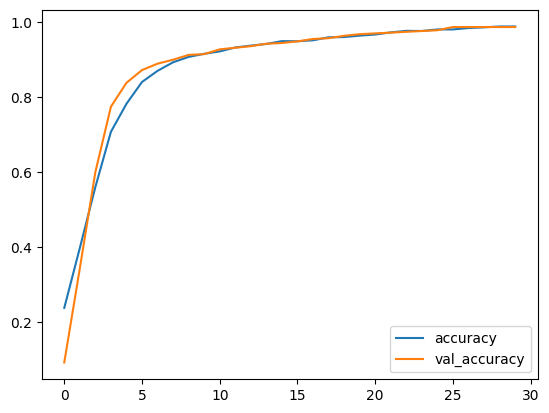

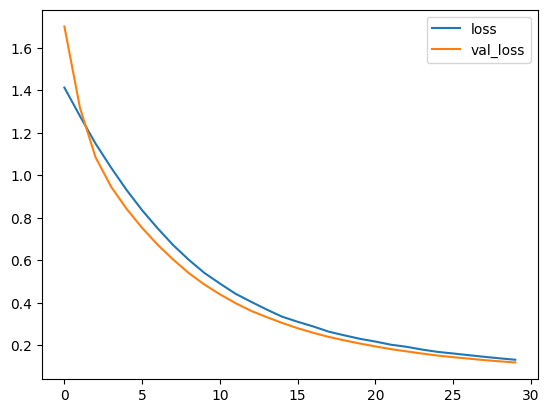

In [ ]:
history = model.fit(
    x=train_imgs,
    y=train_df,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(val_imgs, val_df),
    callbacks=[es_callback, reduce_lr],
    shuffle=True
)

# Plot accuracy and loss
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.show()


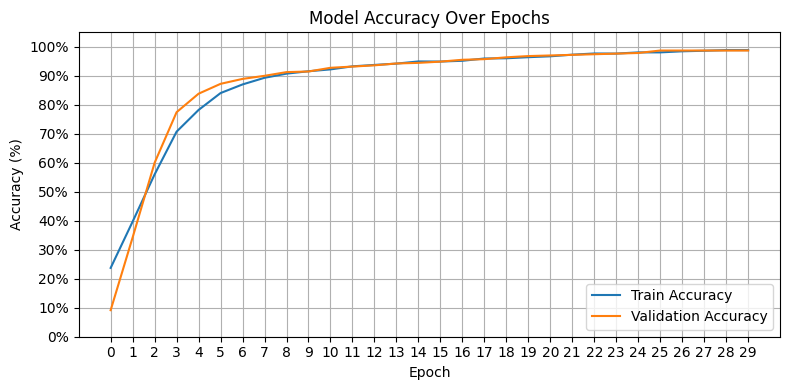

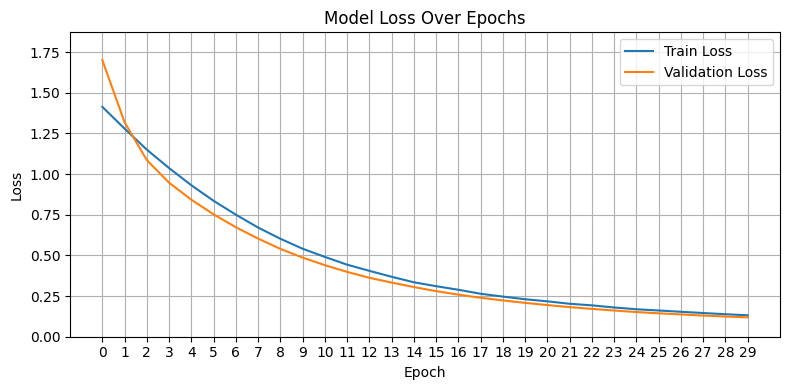

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert training history to DataFrame
history_df = pd.DataFrame(history.history)

# ------------------ Accuracy Plot ------------------
plt.figure(figsize=(8, 4))
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 1.05)
plt.yticks([i/10 for i in range(11)], [f"{i*10}%" for i in range(11)])  # 0%, 10%, ..., 100%
plt.xticks(range(len(history_df)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ------------------ Loss Plot ------------------
plt.figure(figsize=(8, 4))
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, max(history_df[['loss', 'val_loss']].max()) * 1.1)  # auto-scale with small margin
plt.xticks(range(len(history_df)))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import f1_score

# Predict class probabilities
y_pred_probs = model.predict(val_imgs)

# Convert to class labels
y_pred = y_pred_probs.argmax(axis=1)  # shape: (N,)
y_true = val_df.values.argmax(axis=1) if isinstance(val_df, pd.DataFrame) else val_df  # shape: (N,)

# Compute macro-averaged F1 score
f1 = f1_score(y_true, y_pred, average='macro')

print("F1 Score (macro):", round(f1, 4))


15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 507ms/step
F1 Score (macro): 0.9724


In [ ]:
from sklearn.metrics import confusion_matrix

# Ensure true labels and predictions are ready
true_classes = test_df.values  # one-hot encoded (shape: [N, 4])
y_pred = model.predict(test_imgs)
y_pred = (y_pred > 0.5).astype(int)  # binarize

# Compute confusion matrix
cm = confusion_matrix(true_classes.argmax(axis=1), y_pred.argmax(axis=1))

print('Confusion Matrix:')
print(cm)


25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 353ms/step
Confusion Matrix:
[[503   0   0   0]
 [  0  90   0   0]
 [  0   0 129   2]
 [  5   0   1  53]]


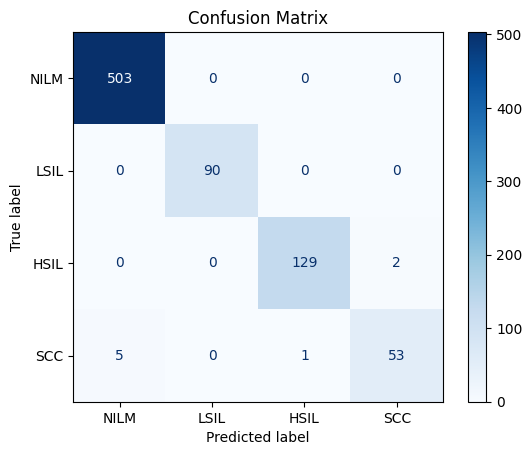

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Get predicted and true class labels (as integers)
y_true_cls = true_classes.argmax(axis=1)     # convert one-hot to class index
y_pred_cls = y_pred.argmax(axis=1)           # same for prediction

# Compute the confusion matrix
cm = confusion_matrix(y_true_cls, y_pred_cls)

# Display the confusion matrix
class_names = ['NILM', 'LSIL', 'HSIL', 'SCC']  # adjust if needed
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', values_format='d')  # show counts with blue color
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()


In [ ]:
from sklearn.metrics import roc_auc_score

# true_classes: one-hot encoded (e.g., shape (N, 4))
# y_pred: softmax probabilities (shape (N, 4))

roc_auc = roc_auc_score(true_classes, y_pred, average='macro', multi_class='ovr')
print('Macro-Averaged ROC AUC Score:', round(roc_auc, 4))


Macro-Averaged ROC AUC Score: 0.9848


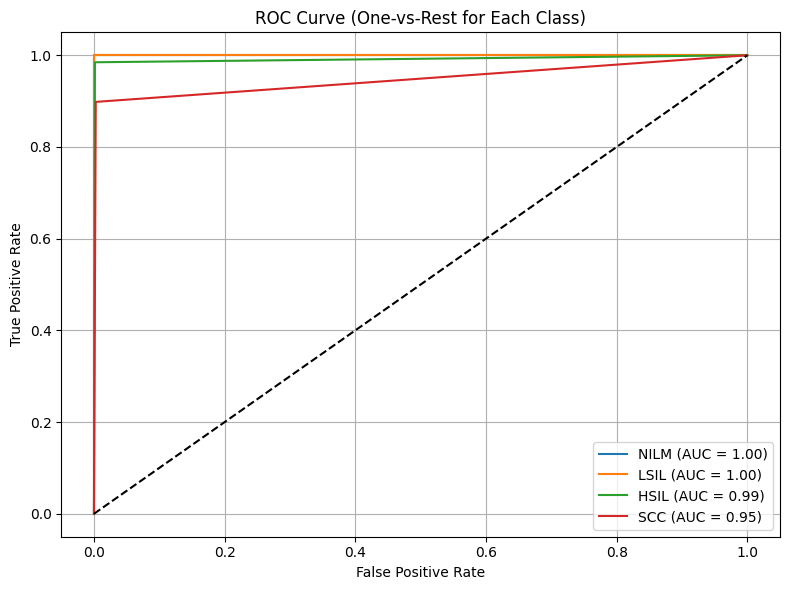

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Class labels (adjust if needed)
classes = ['NILM', 'LSIL', 'HSIL', 'SCC']

# One-hot encoded true labels and predicted probabilities
# true_classes: shape (N, 4)
# y_pred: shape (N, 4)

plt.figure(figsize=(8, 6))

for i in range(true_classes.shape[1]):
    fpr, tpr, _ = roc_curve(true_classes[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (One-vs-Rest for Each Class)')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# Step 1: Convert predictions and true labels to class indices
y_pred_probs = model.predict(test_imgs)

# If predictions are probabilities or one-hot
y_pred = np.argmax(y_pred_probs, axis=1)

# If test_df is a DataFrame with one-hot labels
if isinstance(test_df, pd.DataFrame) and test_df.shape[1] > 1:
    y_true = np.argmax(test_df.values, axis=1)
else:
    y_true = np.array(test_df).flatten()

# Ensure same length
assert len(y_true) == len(y_pred), f"Mismatch: y_true({len(y_true)}) vs y_pred({len(y_pred)})"

# Step 2: Sensitivity and specificity calculation
def calculate_sensitivity_specificity(y_true, y_pred, num_classes=4):
    cm = confusion_matrix(y_true, y_pred, labels=range(num_classes))
    sensitivity_list = []
    specificity_list = []
    for i in range(num_classes):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FP + FN)
        sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
        specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
        sensitivity_list.append(sensitivity)
        specificity_list.append(specificity)
    return sensitivity_list, specificity_list

# Step 3: Compute and print
sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred, num_classes=4)
for i, (sen, spec) in enumerate(zip(sensitivity, specificity)):
    print(f"Class {i} - Sensitivity: {sen:.4f}, Specificity: {spec:.4f}")


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Class 0 - Sensitivity: 1.0000, Specificity: 0.9964
Class 1 - Sensitivity: 1.0000, Specificity: 1.0000
Class 2 - Sensitivity: 0.9847, Specificity: 0.9969
Class 3 - Sensitivity: 0.9492, Specificity: 0.9972


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

# Predict probabilities for 4-class output
y_probs = model.predict(test_imgs)

# Convert to predicted class indices
y_pred = np.argmax(y_probs, axis=1)

# Ground truth labels
if isinstance(test_df, pd.DataFrame):
    y_true = test_df.values.argmax(axis=1)  # if one-hot encoded
else:
    y_true = test_df  # if already integer labels

# Check lengths match
assert len(y_true) == len(y_pred), "Mismatch between y_true and y_pred lengths"

# Classification report
target_names = ["NILM", "LSIL", "HSIL", "SCC"]
print(classification_report(y_true, y_pred, target_names=target_names))

# Optional: Confusion matrix
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
              precision    recall  f1-score   support

        NILM       1.00      1.00      1.00       503
        LSIL       1.00      1.00      1.00        90
        HSIL       0.98      0.98      0.98       131
         SCC       0.97      0.95      0.96        59

    accuracy                           0.99       783
   macro avg       0.99      0.98      0.99       783
weighted avg       0.99      0.99      0.99       783

Confusion Matrix:
[[503   0   0   0]
 [  0  90   0   0]
 [  0   0 129   2]
 [  1   0   2  56]]


In [ ]:

model.evaluate(test_imgs, test_df)

25/25 ━━━━━━━━━━━━━━━━━━━━ 6s 229ms/step - accuracy: 0.9951 - auc_1: 0.9999 - categorical_accuracy: 0.9951 - loss: 0.1060 - precision_1: 0.9971 - recall_1: 0.9904


[0.10915177315473557,
 0.9936143159866333,
 0.9936143159866333,
 0.9897828698158264,
 0.9961439371109009,
 0.9997045397758484]

In [ ]:

from sklearn.metrics import cohen_kappa_score
print("Cohen’s Kappa:", cohen_kappa_score(y_true, y_pred))

Cohen’s Kappa: 0.9881684164717401


k-fold validation

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical

# Convert one-hot labels to integers
train_labels = np.argmax(train_df, axis=1)
X = np.array(train_imgs)
y = np.array(train_labels)

# One-hot encode labels again for training
y_cat = to_categorical(y, num_classes=4)

# Stratified K-Fold setup
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

fold = 1
histories = []

for train_idx, val_idx in kf.split(X, y):
    print(f"\n📂 Fold {fold}")

    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_cat[train_idx], y_cat[val_idx]

    # Build model
    model = build_model(IMG_HEIGHT, IMG_WIDTH, 3)

    # Callbacks
    es_callback = tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

    # Train
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        callbacks=[es_callback, reduce_lr],
        verbose=1
    )

    histories.append(history)
    fold += 1


NameError: name 'train_df' is not defined

In [ ]:
accuracies = []
f1_scores = []
for train_idx, val_idx in kf.split(X, y):
    ...
    history = model.fit(...)  # train model
    val_preds = model.predict(X_val)
    acc = accuracy_score(y_val.argmax(axis=1), val_preds.argmax(axis=1))
    f1 = f1_score(y_val.argmax(axis=1), val_preds.argmax(axis=1), average='macro')
    accuracies.append(acc)
    f1_scores.append(f1)


In [ ]:
import numpy as np

print("Accuracy: Mean = {:.4f}, Std = {:.4f}".format(np.mean(accuracies), np.std(accuracies)))
print("F1 Score: Mean = {:.4f}, Std = {:.4f}".format(np.mean(f1_scores), np.std(f1_scores)))


In [ ]:
import matplotlib.pyplot as plt

plt.boxplot([accuracies, f1_scores], labels=["Accuracy", "F1 Score"])
plt.title("K-Fold Cross-Validation Performance")
plt.grid(True)
plt.show()


paired t-test

In [ ]:
from scipy.stats import ttest_rel

# Assume you have scores from both models
t_stat, p_val = ttest_rel(modelA_scores, modelB_scores)
print(f"P-value: {p_val}")
if p_val < 0.05:
    print("Significant difference between models.")
else:
    print("No significant difference between models.")


NameError: name 'modelA_scores' is not defined

After training Saliency map

In [ ]:
def show_saliency_map(model, image):
    image = tf.convert_to_tensor(image[None], dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(image)
        pred = model(image)
        class_idx = tf.argmax(pred[0])
        loss = pred[:, class_idx]
    grads = tape.gradient(loss, image)[0]
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)

    saliency = (saliency - tf.reduce_min(saliency)) / (tf.reduce_max(saliency) - tf.reduce_min(saliency) + 1e-8)
    plt.imshow(saliency.numpy(), cmap='hot')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()


after training: grad-cam

In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def display_gradcam(img_path, model, last_conv_layer_name='top_conv'):
    img = cv2.imread(img_path)
    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    img_input = tf.keras.applications.efficientnet.preprocess_input(img.copy())
    img_input = np.expand_dims(img_input, axis=0)

    heatmap = make_gradcam_heatmap(img_input, model, last_conv_layer_name)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 0.6, heatmap_color, 0.4, 0)

    plt.imshow(superimposed_img[..., ::-1])
    plt.axis('off')
    plt.title("Grad-CAM")
    plt.show()


after training: occlusion sensitivity

In [ ]:
def occlusion_sensitivity(model, image, patch_size=20, stride=10):
    img_height, img_width, _ = image.shape
    base_img = image.copy()
    base_img_input = np.expand_dims(base_img, axis=0)
    base_img_input = tf.keras.applications.efficientnet.preprocess_input(base_img_input)
    base_score = model.predict(base_img_input)[0]
    class_idx = np.argmax(base_score)

    heatmap = np.zeros((img_height // stride, img_width // stride))
    for y in range(0, img_height - patch_size, stride):
        for x in range(0, img_width - patch_size, stride):
            occluded = base_img.copy()
            occluded[y:y+patch_size, x:x+patch_size] = 0
            occluded_input = tf.keras.applications.efficientnet.preprocess_input(np.expand_dims(occluded, axis=0))
            pred = model.predict(occluded_input)[0]
            drop = base_score[class_idx] - pred[class_idx]
            heatmap[y // stride, x // stride] = drop

    heatmap = cv2.resize(heatmap, (img_width, img_height))
    plt.imshow(heatmap, cmap='viridis')
    plt.title('Occlusion Sensitivity')
    plt.axis('off')
    plt.show()


In [ ]:
img_path = "/content/drive/My Drive/pap_smear/NILM/your_image.jpg"
img = cv2.imread(img_path)
img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))

# Grad-CAM
display_gradcam(img_path, model)

# Saliency Map
img_norm = tf.keras.applications.efficientnet.preprocess_input(img)
show_saliency_map(model, img_norm)

# Occlusion Sensitivity
occlusion_sensitivity(model, img)


NameError: name 'IMG_WIDTH' is not defined

In [ ]:

model.save("model.h5")